<a href="https://colab.research.google.com/github/ayaka-honda/lesson_ai/blob/master/Titanic_80_382.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster
### Modeling achieved 80.382% accuracy


使用した説明変数　：　'Fare', 'Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin_flg'

使用したアルゴリズム　：　RandomForestClassifier

ハイパーパラメータ : max_depth=5, n_estimators=300

In [0]:
# 必要なモジュールのインポート
import pandas as pd
import numpy as np
from numpy.random import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()
%precision 3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# データ読込
train_original=pd.read_csv('train.csv')
train=train_original.copy()

test_original=pd.read_csv('test.csv')
test=test_original.copy()

# データサイズと項目の確認
print('Train Size : ',train.shape)
print('Test Size : ',test.shape)
train.head()

Train Size :  (891, 12)
Test Size :  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# trainデータ数とオブジェクトタイプの確認
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# trainデータの欠損値を確認
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# testデータの欠損値を確認
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 欠損の補完値を決定するためのデータの考察

In [6]:
# 特徴量の相関係数を確認
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [7]:
# 生存者の特徴を確認
train.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [8]:
# クラスごとの特徴を確認
train.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


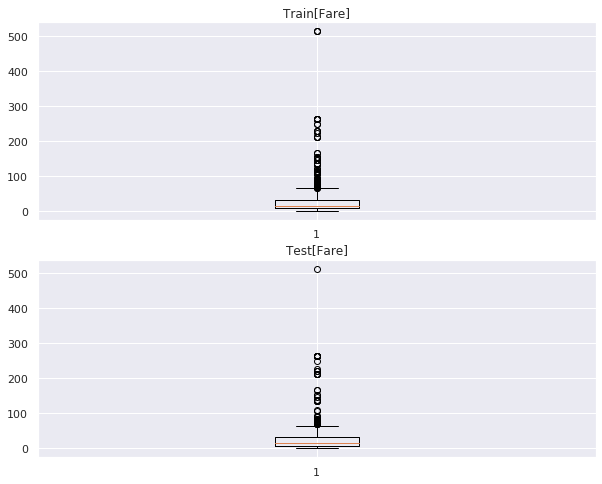

In [9]:
# 'Fare'の分布を確認
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title('Train[Fare]')
plt.boxplot(train['Fare'])

plt.subplot(2,1,2)
plt.title('Test[Fare]')
plt.boxplot(test['Fare'].dropna())
plt.show()

###考察
*   ’Pclass’と'Fare' は'Survived'との相関が高いが、お互いの相関も高い
*   'Age'と'Survived'の相関が予想に反して低い
*   'Fare'はばらつきが大きいがTestデータも同じようなばらつきがある

In [10]:
# Cabinデータが入っているかどうかで生存を確認
train['Cabin_flg']= np.where(train['Cabin'].isnull(), 0,1)
print(train.groupby('Survived')['Cabin_flg'].value_counts())
print('=============================')
print('生存率(Cabin):{:.2f}'.format(136/(206+136)))
print('生存率(Without Cabin):{:.2f}'.format(68/(481+68)))

Survived  Cabin_flg
0         0            481
          1             68
1         0            206
          1            136
Name: Cabin_flg, dtype: int64
生存率(Cabin):0.40
生存率(Without Cabin):0.12


### 考察
Cabinデータが入っている方が生存率が高い

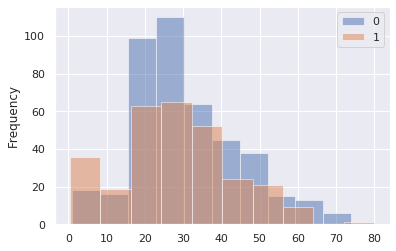

In [11]:
# 年齢別の生存を確認
train.groupby('Survived')['Age'].plot(kind='hist', alpha=0.5)
plt.legend()

###考察
生死の平均年齢の差が２歳しかないので、'Age'に関して重要なのは10才以下である場合と60才以上である場合のみ

In [12]:
# 1０才以下のデータ取得
train[train['Age']<11].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_flg
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S,1
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q,0
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,3,1,349909,21.0750,NaN,S,0
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C,0
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S,0
58,59,1,2,"West, Miss. Constance Mirium",female,5.00,1,2,C.A. 34651,27.7500,NaN,S,0
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S,0
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S,0
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.00,4,2,347082,31.2750,NaN,S,0


In [13]:
# 60才以上のデータ取得
train[train['Age']>59].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_flg
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S,0
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,1
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,1
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S,1
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S,1
275,276,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,13502,77.9583,D7,S,1
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,0
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,D37,C,1


## 考察
*   10才以下のデータ'Name'に１２才以下の男性につけられる敬称「master」や未婚の女性につけられる「miss」の敬称が必ず付けられている
*   10才以下のデータほとんどの'SibSp', 'Parch'には何らか数値が入っている
*   60才以上を仕分ける明確なデータが存在しない

## Trainデータ前処理

*   'Age'の欠損を敬称別の値で補完

*   'Cabin'を２つに分類して欠損を補完
　　　　1.   データなし (0)
　　　　2.   データあり (1)

*   'Embarked'が欠損の行を削除

## Testデータ前処理

*   'Age'の欠損を敬称別の値で補完

*   'Cabin'を２つに分類して欠損を補完
　　　　1.   データなし (0)
　　　　2.   データあり (1)

*   'Fare'の欠損をクラスの平均値で補完



In [14]:
# Title項目を追加(Mr, Mrs, Miss, Master, Other)
# Trainデータ
import re
def change(v):
  data=re.search(r'Mr\.|Mrs\.|Miss\.|Master\.', v)
  if data != None:
    return data.group()

train['Title']= [change(v) for v in train['Name']]
train['Title'].fillna('Other', inplace=True)

# Testデータ
import re
def change(v):
  data=re.search(r'Mr\.|Mrs\.|Miss\.|Master\.', v)
  if data != None:
    return data.group()

test['Title']= [change(v) for v in test['Name']]
test['Title'].fillna('Other', inplace=True)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_flg,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss.
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,Miss.
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,Mr.


In [15]:
# 敬称ごとの年齢の平均値を取得
print('Missの平均値(Train) : {:.2f}'.format(train[train['Title']=='Miss.']['Age'].mean()))
print('Mrsの平均値(Train) : {:.2f}'.format(train[train['Title']=='Mrs.']['Age'].mean()))
print('Masterの平均値(Train) : {:.2f}'.format(train[train['Title']=='Master.']['Age'].mean()))
print('Mrの平均値(Train) : {:.2f}'.format(train[train['Title']=='Mr.']['Age'].mean()))
print('Otherの平均値(Train) : {:.2f}'.format(train[train['Title']=='Other']['Age'].mean()))
print('========================')
print('Missの平均値(Test) : {:.2f}'.format(test[test['Title']=='Miss.']['Age'].mean()))
print('Mrsの平均値(Test) : {:.2f}'.format(test[test['Title']=='Mrs.']['Age'].mean()))
print('Masterの平均値(Test) : {:.2f}'.format(test[test['Title']=='Master.']['Age'].mean()))
print('Mrの平均値(Test) : {:.2f}'.format(test[test['Title']=='Mr.']['Age'].mean()))
print('Otherの平均値(Test) : {:.2f}'.format(test[test['Title']=='Other']['Age'].mean()))

Missの平均値(Train) : 21.77
Mrsの平均値(Train) : 35.90
Masterの平均値(Train) : 4.57
Mrの平均値(Train) : 32.37
Otherの平均値(Train) : 42.38
Missの平均値(Test) : 21.77
Mrsの平均値(Test) : 38.90
Masterの平均値(Test) : 7.41
Mrの平均値(Test) : 32.00
Otherの平均値(Test) : 43.83


In [16]:
# 'Age'の欠損を'Title'ごとの年齢の平均値で補完
# Trainデータ
for v in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Other']:
  train['Age'][train['Title']==v] = train['Age'].fillna(train[train['Title']==v]['Age'].mean())

# Testデータ
for v in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Other']:
  test['Age'][test['Title']==v] = test['Age'].fillna(test[test['Title']==v]['Age'].mean())
train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_flg,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,1,Miss.
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.773973,1,2,W./C. 6607,23.4500,NaN,S,0,Miss.
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,Mr.


In [0]:
# 'Cabin'を２つに分類して欠損を補完
# Testデータ
test['Cabin_flg']= np.where(test['Cabin'].isnull(), 0,1)

In [0]:
# 'Embarked'の欠損を削除
train.dropna(subset=['Embarked'], inplace=True)

In [19]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Cabin_flg        0
Title            0
dtype: int64

In [20]:
# Testデータ　'Fare'の欠損データを確認
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_flg
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr.,0


In [21]:
# 'Fare'の欠損を対象データの'Pclass'の平均値で補完
test['Fare'].fillna(test[test['Pclass']==3]['Fare'].mean(),inplace=True)
test[test['PassengerId']==1044]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_flg
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,12.459678,NaN,S,Mr.,0


In [22]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
Cabin_flg        0
dtype: int64

## モデルの選択

In [0]:
# 使用しない特徴量を削除
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

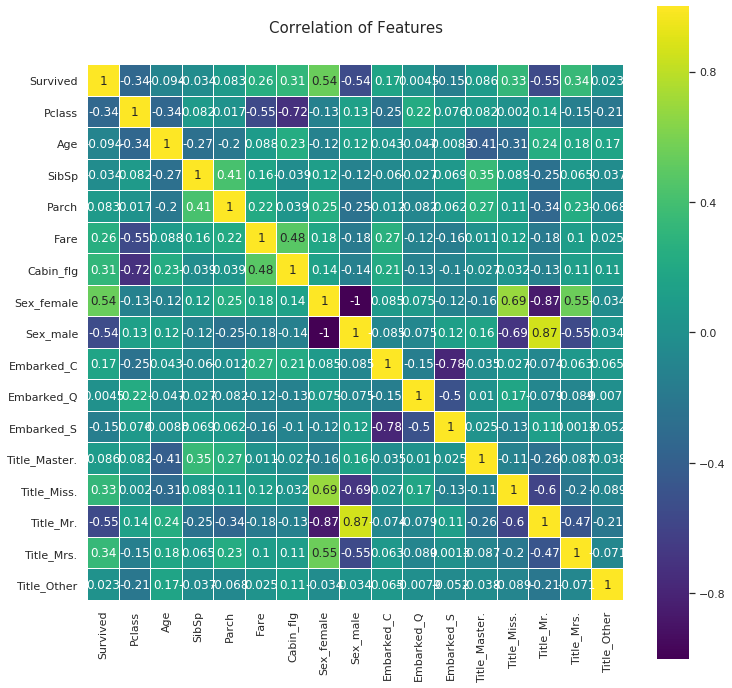

In [24]:
# ヒートマップで特徴量の相関を確認
train_dummies=pd.get_dummies(train)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train_dummies.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

##考察

*   'Sex'と'Title'は相関が高い
*   'Survived'と相関が高いものは’Fare', 'Pclass', 'Sex', 'Cabin_flg'




In [25]:
# 目的変数と説明変数を設定
y=train['Survived']
X= train.drop(['Survived', 'Title'], axis=1)
X_dummies=pd.get_dummies(X)
X_dummies

,Pclass,Age,SibSp,Parch,Fare,Cabin_flg,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,1,0,1,0,0
2,3,26.000000,0,0,7.9250,0,1,0,0,0,1
3,1,35.000000,1,0,53.1000,1,1,0,0,0,1
4,3,35.000000,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,0,1,0,0,1
887,1,19.000000,0,0,30.0000,1,1,0,0,0,1
888,3,21.773973,1,2,23.4500,0,1,0,0,0,1
889,1,26.000000,0,0,30.0000,1,0,1,1,0,0


In [26]:
# Trainデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, stratify=y, test_size=0.3, random_state=0)

# 複数のアルゴリズムでモデルを生成
models = {
    'knn': KNeighborsClassifier(),
    'logistic': LogisticRegression(random_state=0),
    'tree': DecisionTreeClassifier(random_state=0),
    'LinearSVC': LinearSVC(random_state=0),
    'SVC': SVC(random_state=0),
    'RandomForest': RandomForestClassifier(random_state=0)
}
 
scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train')]= model.score(X_train, y_train)
    scores[(model_name, 'test')]= model.score(X_test, y_test)

pd.Series(scores).unstack()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,test,train
LinearSVC,0.808989,0.782958
RandomForest,0.827715,0.975884
SVC,0.749064,0.900322
knn,0.752809,0.774920
logistic,0.827715,0.787781
tree,0.794007,0.991961


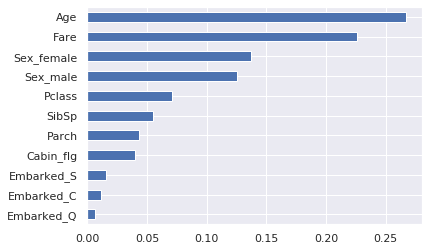

In [27]:
# 特徴量の重要度をグラフ化
s=pd.Series(models['RandomForest'].feature_importances_, index=X_dummies.columns)
s.sort_values(ascending=True).plot.barh()

###説明変数の再設定とモデルの実装

In [28]:
y=train['Survived']
X=train[['Fare', 'Age', 'Pclass', 'Sex','SibSp','Parch','Cabin_flg']]
X_dummies=pd.get_dummies(X)
X_dummies

,Fare,Age,Pclass,SibSp,Parch,Cabin_flg,Sex_female,Sex_male
0,7.2500,22.000000,3,1,0,0,0,1
1,71.2833,38.000000,1,1,0,1,1,0
2,7.9250,26.000000,3,0,0,0,1,0
3,53.1000,35.000000,1,1,0,1,1,0
4,8.0500,35.000000,3,0,0,0,0,1
...,...,...,...,...,...,...,...,...
886,13.0000,27.000000,2,0,0,0,0,1
887,30.0000,19.000000,1,0,0,1,1,0
888,23.4500,21.773973,3,1,2,0,1,0
889,30.0000,26.000000,1,0,0,1,0,1


In [29]:
# Trainデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, stratify=y, test_size=0.3, random_state=0)

# モデルの生成
models = {
    'knn': KNeighborsClassifier(),
    'logistic': LogisticRegression(random_state=0),
    'tree': DecisionTreeClassifier(random_state=0),
    'LinearSVC': LinearSVC(random_state=0),
    'SVC': SVC(random_state=0),
    'RandomForest': RandomForestClassifier(random_state=0)
}
 
scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train')]= model.score(X_train, y_train)
    scores[(model_name, 'test')]= model.score(X_test, y_test)

pd.Series(scores).unstack()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,test,train
LinearSVC,0.745318,0.689711
RandomForest,0.846442,0.975884
SVC,0.749064,0.898714
knn,0.752809,0.778135
logistic,0.827715,0.779743
tree,0.801498,0.991961


In [30]:
# ハイパーパラメータの設定
pram_grid={'max_depth':range(2,10), 'n_estimators':[5, 10, 20, 30, 50, 100, 300]}
rf=RandomForestClassifier(random_state=0)
grid_search=GridSearchCV(rf, pram_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Score(Test):{:.2f}'.format(grid_search.score(X_test, y_test)))
print('Best prams:{}'.format(grid_search.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score(Test):0.85
Best prams:{'max_depth': 5, 'n_estimators': 300}


In [31]:
# パラメータを設定してモデルを実装
rf=RandomForestClassifier(max_depth=5, n_estimators=300, random_state=0)
rf.fit(X_train, y_train)

print('score(train):{}'.format(rf.score(X_train, y_train)))
print('score(test):{}'.format(rf.score(X_test, y_test)))

score(train):0.8488745980707395
score(test):0.846441947565543


In [32]:
# Testデータの説明変数を設定
X_test= test[['Fare', 'Age', 'Pclass', 'Sex','SibSp','Parch','Cabin_flg']]
X_test_dummies=pd.get_dummies(X_test)
X_test_dummies

,Fare,Age,Pclass,SibSp,Parch,Cabin_flg,Sex_female,Sex_male
0,7.8292,34.500000,3,0,0,0,0,1
1,7.0000,47.000000,3,1,0,0,1,0
2,9.6875,62.000000,2,0,0,0,0,1
3,8.6625,27.000000,3,0,0,0,0,1
4,12.2875,22.000000,3,1,1,0,1,0
...,...,...,...,...,...,...,...,...
413,8.0500,32.000000,3,0,0,0,0,1
414,108.9000,39.000000,1,0,0,1,1,0
415,7.2500,38.500000,3,0,0,0,0,1
416,8.0500,32.000000,3,0,0,0,0,1


In [0]:
# 予測
predict = rf.predict(X_test_dummies)

In [34]:
# 結果の出力
test_original['Survived']=predict
result=test_original[['PassengerId','Survived']]
result.set_index('PassengerId', inplace=True)
result

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [0]:
result.to_csv('titanic_result.csv')